In [1]:
import gurobipy as gp
from gurobipy import GRB
# 创建模型
model = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-03


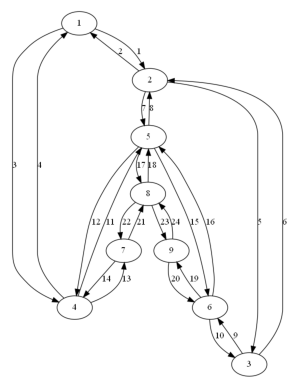

' # 测试 get_upstream() 方法\nlink_number = 4  # 要查询上游的link编号\nupstream_links = get_upstream(grid_graph, link_number)\nprint(f"Link {link_number} 的上游链接编号集合：{upstream_links}")\n\n# 测试 get_downstream() 方法\nlink_number = 7  # 要查询下游的link编号\ndownstream_links = get_downstream(grid_graph, link_number)\nprint(f"Link {link_number} 的下游链接编号集合：{downstream_links}") '

In [2]:
import pygraphviz as pgv
import matplotlib.pyplot as plt
import io

def generate_grid_graph(a):
    # 创建有向图
    graph = pgv.AGraph(directed=True)
    
    # 添加节点
    node_counter = 1  # 节点计数器
    for i in range(a):
        for j in range(a):
            node_name = str(node_counter)
            graph.add_node(node_name)
            node_counter += 1
    
    # 添加边
    edge_counter = 1  # 边计数器
    for i in range(a):
        for j in range(a):
            node_name = str(i * a + j + 1)
            
            # 添加向右的边
            if j < a - 1:
                right_node_name = str(i * a + j + 2)
                graph.add_edge(node_name, right_node_name, label=str(edge_counter))
                graph.add_edge(right_node_name, node_name, label=str(edge_counter + 1))
                edge_counter += 2
            
            # 添加向下的边
            if i < a - 1:
                down_node_name = str((i + 1) * a + j + 1)
                graph.add_edge(node_name, down_node_name, label=str(edge_counter))
                graph.add_edge(down_node_name, node_name, label=str(edge_counter + 1))
                edge_counter += 2
    
    return graph

def visualize_graph(graph):
    # 可视化图形
    graph.layout(prog='dot')
    img_stream = graph.draw(format='png', prog='dot')
    
    # 显示图像
    img = plt.imread(io.BytesIO(img_stream))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


def get_upstream(graph, link):
    upstream_links = set()
    for edge in graph.edges():
        if edge.attr['label'] == str(link):
            source_node = edge[0]
            for inward_edge in graph.in_edges(source_node):
                upstream_link = int(inward_edge.attr['label'])
                if upstream_link != link:
                    upstream_links.add(upstream_link)
            break
    return upstream_links


def get_downstream(graph, link):
    downstream_links = set()
    for edge in graph.edges():
        if edge.attr['label'] == str(link):
            target_node = edge[1]
            for outward_edge in graph.out_edges(target_node):
                downstream_link = int(outward_edge.attr['label'])
                if downstream_link != link:
                    downstream_links.add(downstream_link)
            break
    return downstream_links


# 生成网格图
a = 3  # 每行每列的节点数
grid_graph = generate_grid_graph(a)

# 可视化图形
visualize_graph(grid_graph)

""" # 测试 get_upstream() 方法
link_number = 4  # 要查询上游的link编号
upstream_links = get_upstream(grid_graph, link_number)
print(f"Link {link_number} 的上游链接编号集合：{upstream_links}")

# 测试 get_downstream() 方法
link_number = 7  # 要查询下游的link编号
downstream_links = get_downstream(grid_graph, link_number)
print(f"Link {link_number} 的下游链接编号集合：{downstream_links}") """

In [3]:
M=6  #观测时间段共有M个，每个时间段持续5min
N=24 #共有N条link
K=1 #共有K起事故
M_range = range(1,M+1)
N_range = range(1,N+1)
K_range = range(1,K+1)

P = model.addVars(N, M, vtype=GRB.BINARY, name="P")
#origin_link_index = 5  # 事故发生link
#origin_time_index = 1  # 事故发生时间

m = gp.Model("mip1")


In [4]:
# 创建决策变量
gamma  = m.addVars(K,M,N,vtype=GRB.BINARY, name="gamma") #link n在时间区间m上确实受到了事故k影响则为1
delta  = m.addVars(K,M,N,vtype=GRB.BINARY, name="delta") #事故k起源于在时间区间m上的link n则为1
lambda1 = model.addVar(vtype=gp.GRB.BINARY, name="lambda1")
lambda2 = model.addVar(vtype=gp.GRB.BINARY, name="lambda2")
lambda3 = model.addVar(vtype=gp.GRB.BINARY, name="lambda3")
lambda4 = model.addVar(vtype=gp.GRB.BINARY, name="lambda4")
lambda5 = model.addVar(vtype=gp.GRB.BINARY, name="lambda5")
lambda6 = model.addVar(vtype=gp.GRB.BINARY, name="lambda6")



In [5]:
#目标函数
m.setObjective(gp.quicksum(P[n,m]*(1-delta[k,m,n])+(1-P[m,n])*delta[k,m,n] for k in K_range for m in M_range for n in N_range), GRB.MINIMIZE)

KeyError: (1, 1, 1)

In [ ]:
#约束1-2 保证冲击波的定向传播
#约束1：如果cell<m,n>受到了事故影响，且不是起源cell，那么该影响势必源自下游link或前一时刻或二者兼具
m.addConstrs((gp.quicksum(delta[k,m,l]for l in range(get_downstream(grid_graph, n)))+delta[k,m-1,n]>=delta[k,m,n]-gamma[k,m,n] for k in K_range for m in M_range for n in N_range), "c1")

In [ ]:
#约束3-6 保证冲击波的不间断传播
#约束3：
m.addConstrs((delta[k,m-1,n]<=lambda1 for k in K_range for m in M_range for n in N_range),"c3")
#约束4：
m.addConstrs((gp.quicksum(delta[k,m,l]for l in range(get_downstream(grid_graph, n)))<=lambda2*len(get_downstream(grid_graph, n)) for k in K_range for m in M_range for n in N_range), "c4")
#约束5:
m.addConstrs((delta[k,m,n]>=1-lambda3 for k in K_range for m in M_range for n in N_range),"c5")
#约束6:
m.addConstrs((lambda1+lambda2+lambda3<=2),"c6")

In [ ]:
#约束7-10 当某一link受到事故影响，且该link的上游link也受到了事故影响，那么该link的其余上游link中，车道累计车辆数大于被影响的上游link的，也都应该被事故影响了
#约束7:
m.addConstrs((gp.quicksum(delta[k,m,l]for l in range(get_upstream(grid_graph, n)))<=lambda4*len(get_upstream(grid_graph, n)) for k in K_range for m in M_range for n in N_range), "c7")
#约束8:


In [ ]:
#约束11：针对每一起事故，有且仅有一个cell是事故的起源点
m.addConstrs((gp.quicksum(gamma(k,m,n)for m in M_range for n in N_range)==1 for k in K_range), "c11")

In [ ]:
#约束12：如果cell<m,n>是起源点(终止点)，那么其必会受到事故的影响
m.addConstrs((gamma[k,m,n]<=delta[k,m,n]for k in K_range for m in M_range for n in N_range), "c12")

In [ ]:
#约束13-14 当cell<m,n>是起源点时，前一时刻与上游路段集合的cell都不会受到事故影响
#约束13：
m.addConstrs((gp.quicksum(delta[k,m,l]for l in range(get_upstream(grid_graph, n)))<=(1-gamma[k,m,n])*len(get_upstream(grid_graph, n))for k in K_range for m in M_range for n in N_range), "c13")
#约束14：
m.addConstrs((1-gamma[k,m,n]>=delta[k,m-1,n]for k in K_range for m in M_range for n in N_range), "c14")
#约束15:反之亦然
m.addConstrs((gp.quicksum(delta[k,m,l]for l in range(get_upstream(grid_graph, n)))+delta[k,m-1,n]>=delta[k,m,n]-gamma[k,m,n]for k in K_range for m in M_range for n in N_range), "c15")

In [ ]:
#约束16：针对每一个cell，其产生的拥堵影响只会归属于一起事故
m.addConstrs((gp.quicksum(delta(k,m,n)for k in K_range)==1 for m in M_range for n in N_range), "c16")

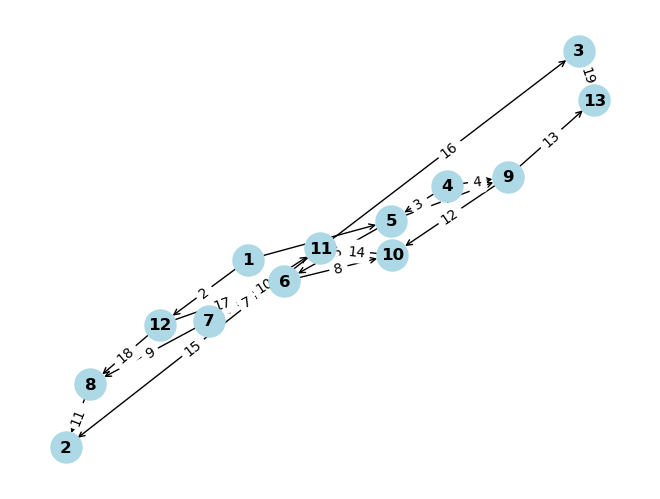

Upstream edges of edge 5: {1, 3}
Downstream edges of edge 9: {11}


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_network():
    # 创建一个有向图
    G = nx.DiGraph()

    # 添加节点
    nodes = range(1, 14)
    G.add_nodes_from(nodes)

    # 添加有向边
    edges = [(1, 5), (1, 12), (4, 5), (4, 9), (5, 6), (5, 9), (6, 7), (6, 10),
             (7, 8), (7, 11), (8, 2), (9, 10), (9, 13), (10, 11), (11, 2),
             (11, 3), (12, 6), (12, 8), (13, 3)]
    G.add_edges_from(edges)

    # 设置节点属性
    node_labels = {node: str(node) for node in G.nodes}
    nx.set_node_attributes(G, node_labels, 'label')

    # 设置边属性
    edge_labels = {(edge[0], edge[1]): i for i, edge in enumerate(edges, 1)}
    nx.set_edge_attributes(G, edge_labels, 'label')

    # 绘制图形
    pos = nx.spring_layout(G)  # 指定节点位置布局
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=500, arrowstyle='->', arrowsize=10,
            font_size=12, font_weight='bold')

    # 添加边标签
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # 显示图形
    plt.show()

    return G

def get_upstream(G, edge_label):
    upstream_edges = set()
    for edge in G.in_edges():
        if G.edges[edge]['label'] == edge_label:
            start_node = edge[0]
            upstream_edges.update(G.edges[edge]['label'] for edge in G.in_edges(start_node))
    return upstream_edges

def get_downstream(G, edge_label):
    downstream_edges = set()
    for edge in G.out_edges():
        if G.edges[edge]['label'] == edge_label:
            end_node = edge[1]
            downstream_edges.update(G.edges[edge]['label'] for edge in G.out_edges(end_node))
    return downstream_edges

# 生成网络
network = generate_network()

# 测试 get_upstream() 方法
edge_label = 5
upstream_edges = get_upstream(network, edge_label)
print(f"Upstream edges of edge {edge_label}: {upstream_edges}")

# 测试 get_downstream() 方法
edge_label = 9
downstream_edges = get_downstream(network, edge_label)
print(f"Downstream edges of edge {edge_label}: {downstream_edges}")